<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li><li><span><a href="#-Комментарий-ревьюера" data-toc-modified-id="-Комментарий-ревьюера-6"><span class="toc-item-num">6&nbsp;&nbsp;</span> Комментарий ревьюера</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import HourLocator 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

R=3456

Столбец с датой и временем сразу преобразуем в Datetime и установим в качестве индекса:

In [185]:
taxi=pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, упорядочены ли записи по времени (индексу):

In [186]:
taxi.index.is_monotonic

True

In [187]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


В таблице содержится 26496 записей. Период измерений - 10 минут, диапазон записей - с 1 марта по 31 августа 2018 года. Тип целевой переменной - целочисленный.

зададим в качестве интервала 1 час:

In [188]:
taxi = taxi.resample('1H').sum()
print('Количество записей после ресемплинга:', taxi.shape[0])

Количество записей после ресемплинга: 4416


## Анализ

Построим график количества заказов в зависимости от времени:

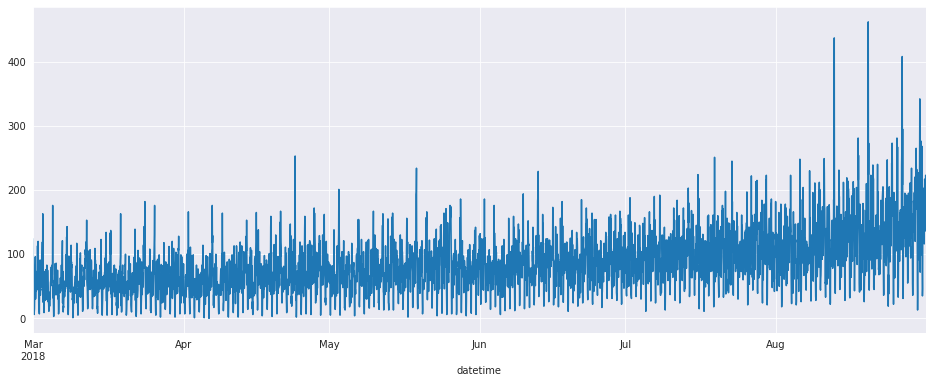

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


In [189]:
taxi['num_orders'].plot(figsize=(16,6))
plt.show()
taxi.describe().transpose()

Целевая переменная принимает значения от 0 до 462 со средним в районе 84 заказов в час и стандартным отклонением в 45.

Разложим наш временной ряд на тренд и сезонные колебания с помощью функции seasonal_decompose.

In [190]:
decomposed = seasonal_decompose(taxi['num_orders'])

Построим графики для каждой составляющей:

(None, <matplotlib.legend.Legend at 0x7f4dc4580990>)

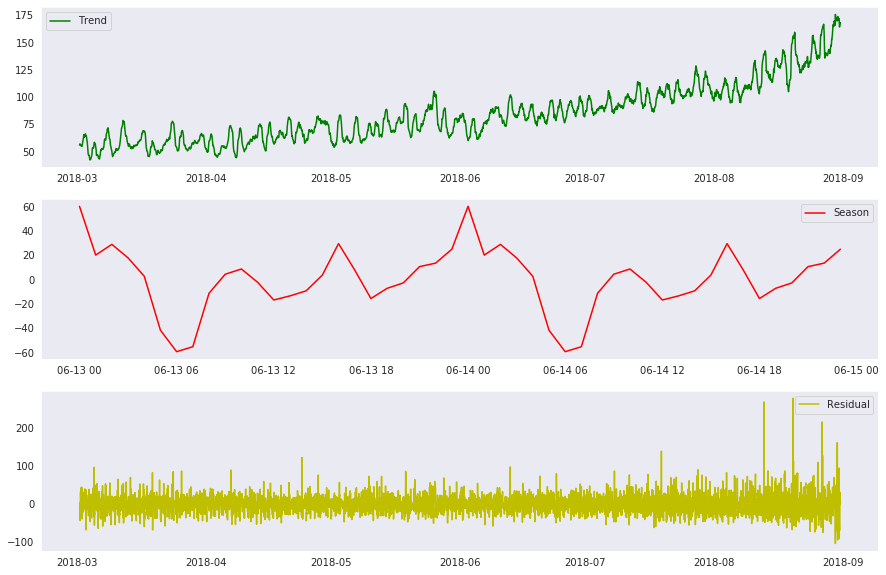

In [191]:
from matplotlib.dates import HourLocator 
fig , ax = plt.subplots(1,3, figsize=(15, 10))

plt.subplot(3,1,1)
plt.plot(decomposed.trend, color = 'g', label = 'Trend')
plt.legend(), plt.grid()


plt.subplot(3,1,2)
plt.plot(decomposed.seasonal['2018-06-13':'2018-06-14'] ,  label = 'Season', color = 'r')
plt.grid(), plt.legend()


plt.subplot(3,1,3)
plt.plot(decomposed.resid , label = 'Residual', color = 'y')
plt.grid(), plt.legend()
 

Тренд указывает на увеличение заказов. Белый шум  со средним отклонением в районе 0. По сезонности можно увидеть как меняется количество заказов в течении дня и наблюдать повторяемость этого на следующий день, можем отметить высокий спрос в ночное время.

С учетом произведенного анализа добавим в таблицу столбцы с календарными признаками.

In [192]:
taxi['month'] = taxi.index.month
taxi['day'] = taxi.index.day
taxi['weekday'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour
taxi.head()

,num_orders,month,day,weekday,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4


Создадим признаки для обучения модели.

In [193]:
def make_features(taxi, max_lag, rolling_mean_size):
  
    taxi['month'] = taxi.index.month
    taxi['day'] = taxi.index.day
    taxi['weekday'] = taxi.index.dayofweek
    taxi['hour'] = taxi.index.hour
    
    for i in range(1,max_lag+1):
        taxi['lag_{}'.format(i)]=taxi['num_orders'].shift(i)
    taxi['rolling_mean']=taxi['num_orders'].shift().rolling(window=rolling_mean_size).mean()
    return taxi

make_features(taxi, 20,24)
taxi=taxi.fillna(0)
taxi.shape

(4416, 26)

In [194]:
taxi.tail().T

datetime,2018-08-31 19:00:00,2018-08-31 20:00:00,2018-08-31 21:00:00,2018-08-31 22:00:00,2018-08-31 23:00:00
num_orders,136.000,154.000000,159.000000,223.000000,205.000
month,8.000,8.000000,8.000000,8.000000,8.000
day,31.000,31.000000,31.000000,31.000000,31.000
weekday,4.000,4.000000,4.000000,4.000000,4.000
hour,19.000,20.000000,21.000000,22.000000,23.000
lag_1,207.000,136.000000,154.000000,159.000000,223.000
lag_2,217.000,207.000000,136.000000,154.000000,159.000
lag_3,197.000,217.000000,207.000000,136.000000,154.000
lag_4,116.000,197.000000,217.000000,207.000000,136.000
lag_5,133.000,116.000000,197.000000,217.000000,207.000


Выделим целевой признак в переменную target, а остальные сохраним в features:
    

In [195]:
features = taxi.drop(columns = ['num_orders'])
target = taxi['num_orders']

Разобьем данные на обучающую и тестовую выборки (без перемешивания):

In [196]:
train_feats, test_feats, train_target, test_target = train_test_split(features, 
                                                                      target,
                                                                      train_size=0.9,
                                                                      shuffle=False)

In [197]:
print(f'''Размеры выборок:

Обучающая \t {train_feats.shape[0]}
Тестовая \t {test_feats.shape[0]}''')

Размеры выборок:

Обучающая 	 3974
Тестовая 	 442


## Обучение

В качестве базовой модели, с которой мы будем сравнивать качество работы наших регрессоров, используем линейную регрессию:

Результаты:
 RMSE на тренировочных данных: 27.8983, RMSE на тестовых данных: 49.3101,
 время обучения: 0.0055 с.


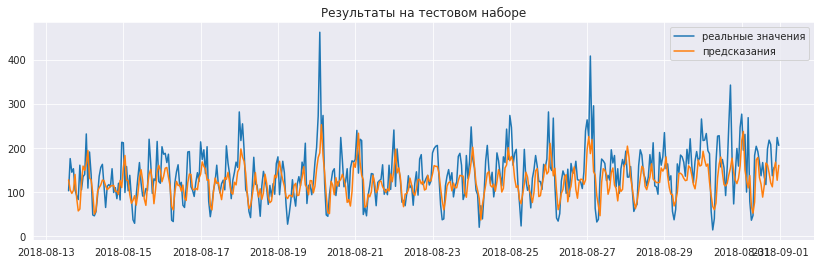

In [198]:
def model_quick_test(model, plot=None, silent=None):
    t_0 = time()
    model.fit(train_feats, train_target)
    t_fit = time() - t_0
    train_pred = model.predict(train_feats)
    train_rmse = mean_squared_error(train_pred, train_target) ** 0.5
    test_pred = model.predict(test_feats)
    test_rmse = mean_squared_error(test_pred, test_target) ** 0.5
    if not silent:
        print('Результаты:\n',
              f'RMSE на тренировочных данных: {round(train_rmse, 4)}, RMSE на тестовых данных: {round(test_rmse, 4)},\n',
              f'время обучения: {round(t_fit, 4)} с.')
    if plot:                                    
        plt.figure(figsize=(14, 4))
        plt.plot(test_target, label="реальные значения")
        plt.plot(test_target.index, test_pred, label="предсказания")
        plt.legend(loc="best")
        plt.title('Результаты на тестовом наборе')
        plt.show()
    return train_rmse, test_rmse, t_fit


results = pd.DataFrame(columns=['RMSE на тренировочном наборе', 
                                'RMSE на тестовом наборе', 
                                'Время обучения'])
results.loc['Linear Regression'] = model_quick_test(LinearRegression(), plot=1)

Обучаем модель на основе алгоритма "Случайный лес"

Результаты:
 RMSE на тренировочных данных: 8.365, RMSE на тестовых данных: 43.9794,
 время обучения: 8.469 с.


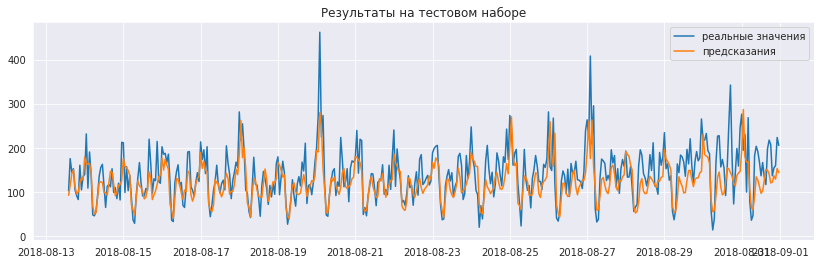

In [199]:
results.loc['Random Forest'] = model_quick_test(RandomForestRegressor(n_estimators= 100, random_state=123), plot=1)

Рассмотрим модель на основе градиентного бустинга. Воспользуемся пакетом Light GBM. Быстро оценим качество работы регрессора:

In [200]:
model = lgb.LGBMRegressor(random_state=R)
_ = model_quick_test(model)

Результаты:
 RMSE на тренировочных данных: 12.5719, RMSE на тестовых данных: 43.172,
 время обучения: 19.7136 с.


Результат получен неплохой, подберем оптимальные гиперпараметры для LGBM-регрессора.

Воспользуемся решетчатым поиском. Зададим пространство параметров:

In [201]:
param_grid = {'learning_rate': [0.03, 0.01, 0.005],
              'n_estimators': [100, 500, 600],
              'max_depth': [2, 3, 4],
              'reg_lambda': [0, 0.1, 1],
              'bagging_fraction': [0.5, 1],
              'feature_fraction': [0.4, 0.5],}

Стандартный метод кроссвалидации по фолдам для временных рядов не подходит, используем для разбиения сплиттер TimeSeriesSplit:

In [202]:
tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid.fit(train_feats, train_target)
print('Лучшая метрика на кросс-валидации:', grid.best_score_*(-1), ', оптимальные гиперпараметры:')
for x in grid.best_params_:
    print(x,':', grid.best_params_[x])

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] bagging_fraction=0.5, feature_fraction=0.4, learning_rate=0.03, max_depth=2, n_estimators=100, reg_lambda=0 
[CV]  bagging_fraction=0.5, feature_fraction=0.4, learning_rate=0.03, max_depth=2, n_estimators=100, reg_lambda=0, total=   0.1s
[CV] bagging_fraction=0.5, feature_fraction=0.4, learning_rate=0.03, max_depth=2, n_estimators=100, reg_lambda=0 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  bagging_fraction=0.5, feature_fraction=0.4, learning_rate=0.03, max_depth=2, n_estimators=100, reg_lambda=0, total=   0.3s
[CV] bagging_fraction=0.5, feature_fraction=0.4, learning_rate=0.03, max_depth=2, n_estimators=100, reg_lambda=0 
[CV]  bagging_fraction=0.5, feature_fraction=0.4, learning_rate=0.03, max_depth=2, n_estimators=100, reg_lambda=0, total=   0.3s
[CV] bagging_fraction=0.5, feature_fraction=0.4, learning_rate=0.03, max_depth=2, n_estimators=100, reg_lambda=0.1 
[CV]  bagging_fraction=0.5, feature_fraction=0.4, learning_rate=0.03, max_depth=2, n_estimators=100, reg_lambda=0.1, total=   0.3s
[CV] bagging_fraction=0.5, feature_fraction=0.4, learning_rate=0.03, max_depth=2, n_estimators=100, reg_lambda=0.1 
[CV]  bagging_fraction=0.5, feature_fraction=0.4, learning_rate=0.03, max_depth=2, n_estimators=100, reg_lambda=0.1, total=   0.3s
[CV] bagging_fraction=0.5, feature_fraction=0.4, learning_rate=0.03, max_depth=2, n_estimators=100, reg_lambda=0.1 
[CV]  bagging_frac

[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 21.5min finished


Лучшая метрика на кросс-валидации: 737.1660489120147 , оптимальные гиперпараметры:
bagging_fraction : 0.5
feature_fraction : 0.4
learning_rate : 0.03
max_depth : 4
n_estimators : 600
reg_lambda : 0


Проверим качество работы модели с подобранными параметрами на тестовой выборке:

Результаты:
 RMSE на тренировочных данных: 16.0682, RMSE на тестовых данных: 42.6688,
 время обучения: 2.6737 с.


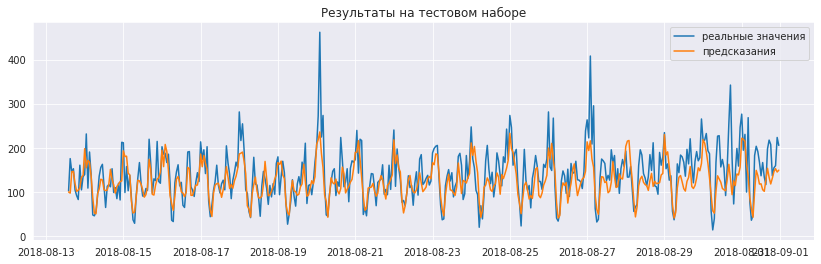

In [203]:
model = lgb.LGBMRegressor(**grid.best_params_)
results.loc['Gradient Boosting'] = model_quick_test(model, plot=1)

Воспользуемся библиотекой CatBoost, создатели обещают отличное качество без настройки гиперпараметров.

Результаты:
 RMSE на тренировочных данных: 13.8364, RMSE на тестовых данных: 42.671,
 время обучения: 27.4615 с.


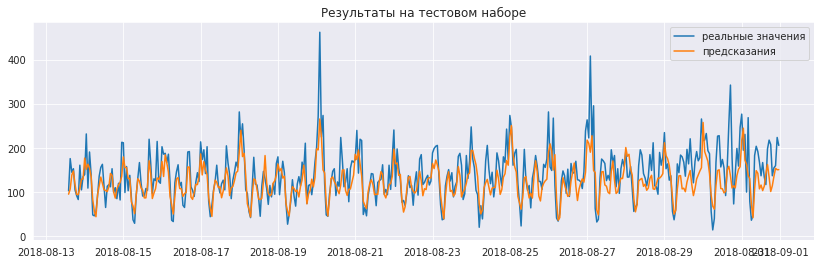

In [204]:
model = CatBoostRegressor(verbose=False)
results.loc['CatBoostRegressor'] = model_quick_test(model, plot=1)

## Тестирование

В итоге мы получили следующие результаты:

In [205]:
results.sort_values('RMSE на тестовом наборе')

,RMSE на тренировочном наборе,RMSE на тестовом наборе,Время обучения
Gradient Boosting,16.068163,42.668790,2.673742
CatBoostRegressor,13.836434,42.670999,27.461501
Random Forest,8.365043,43.979433,8.468998
Linear Regression,27.898336,49.310119,0.005536


Во время проекта были изучены способы предсказания веременных рядов за счет регрессоров.
Линейная регрессия показывает весьма неплохой результат, который уже почти укладывается в требования задания (RMSE меньше 48).
Лидером по совокупности рассматриваемых показателей стал Gradient BoostingCatBoostRegressor с подбором лучших гиперпараметров. CatBoostRegressor с автоматическим подбором гиперпараметров незначительно уступает по результату, но тратит гораздо больше времени. RandomForest	показывает приемлемые результаты за достаточно короткое время.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48